In [28]:
import numpy as np
from Gridworld import *
import torch 
import random
from matplotlib import pylab as plt

In [29]:
game = Gridworld(size=4, mode='static')

In [30]:
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [31]:
game.makeMove('r')
print(game.reward())


-1


In [32]:
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [33]:
a = np.random.rand(1,6)

In [34]:
np.argmax(a)

4

In [35]:
b = torch.Tensor(a)

In [36]:
b

tensor([[0.5214, 0.0681, 0.6126, 0.6599, 0.9991, 0.8408]])

In [37]:
c = torch.from_numpy(a).float()

In [38]:
c==b

tensor([[True, True, True, True, True, True]])

In [39]:

action_set = ['l','r','u','d']

Configuration of NN

input layer = 4* 4* 4 = 64

hidden layer1 = 150

hidden layer2 = 100

output layer = 4 (No. of actions)

In [40]:
l1 = 64
l2 = 150
l3 = 100
l4 = 4

### Review of model in torch


In [41]:
model = torch.nn.Sequential(torch.nn.Linear(l1,l2),torch.nn.ReLU(),
                           torch.nn.Linear(l2,l3), torch.nn.ReLU(),
                           torch.nn.Linear(l3,l4))

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

Procedure:

1. set up for loop for no. of epochs
2. set up while loop till the game is progressing
3. Run Q-network with input S_t
4. Take action by epsilon greedy-policy
5. Note the next state (S_t+1) and reward R_t+1
6. Run the Q-network on S_t+1 and take the maximum Q-value (max Q(S_t+1))
7. Target value is R_t+1 + max Q(S_t+1)
8. Optimize the parameters for this target value, i.e, change the output vector corresponding action to the target value.
9. On the last step target value is the reward itself.

In [42]:
epochs = 1000
losses =[]

for i in range(epochs):
    game = Gridworld(size=4, mode='static')
    state = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10
    state_ = torch.Tensor(state)
    status = 1
    while(status == 1):
        #getting Q value
        qval = model(state_)
        qval_ = qval.data.numpy()
        
        #choosing action epsilon greedy
        if(random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        
        game.makeMove(action)
        
        #recording new state and reward
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10
        state2 = torch.Tensor(state2_)
        reward = game.reward()
        
        #getting new Qval
        with torch.no_grad():
            qval2 = model(state2.reshape(1,64))
        
        #qval2_ = qval2.data.numpy()
        #maxQ2 = np.max(qval2_)
        
        #calculation of target reward
        maxQ2 = torch.max(qval2)
        #target_qval = qval_.copy()
        if reward ==-1:
            y = reward + gamma*maxQ2
        else:
            y = reward 
            status = 0
        
        #calculating loss for this step
        #target_qval[action_] = y
        #target_qval = torch.Tensor(target_qval)
        #qval_ = torch.Tensor(qval_)
        y = torch.Tensor([y]).detach()
        x = qval.squeeze()[action_]
        loss = loss_fn(x,y)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state_ = state2
    
    if epsilon > 0.1:
        epsilon -= (1/epochs)

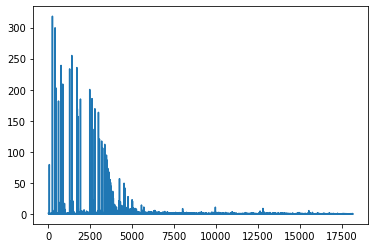

In [43]:
plt.plot(range(len(losses)),losses)

In [55]:
def test(model,mode='static',display=True):
    game = Gridworld(mode = mode)
    state_ = game.board.render_np().reshape(1,64)+np.random.rand(1,64)/10
    state = torch.Tensor(state_)
    status = 1
    i=1
    if display:
        print('Initial State')
        print(game.display())
    while(status==1):
        qval = model(state)
        qval_ = qval.data.numpy()
        
        action_ = np.argmax(qval_)
        action = action_set[action_]
        game.makeMove(action)
        state_ = game.board.render_np().reshape(1,64)+np.random.rand(1,64)/10
        state = torch.Tensor(state_)
        reward = game.reward()
        if display:
            print("Move ",i)
            print('Action taken: '+action)
            print("State Reached")
            print(game.display())
            print("Reward : ",reward)
        if reward != -1:
            status=0
            if reward > 0:
                if display:
                    print("You won")
                return True
            else:
                if display:
                    print("You fell")
                return False
        i+=1
        
        if(i>15):
            if display:
                print("Too many moves")
                break
    
    return False
        
        

In [53]:
test(model)

Initial State
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[[8.208977 6.593728 5.94521  6.221051]]
Move  1
Action taken: l
State Reached
[['+' '-' 'P' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Reward :  -1
[[9.662777  5.364772  6.9723167 7.1827655]]
Move  2
Action taken: l
State Reached
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Reward :  -10
You fell


False

## Experience Buffer
It is used to avoid catastrophic memory

In dynamic mode the position of obstacles can change, in that case, the agent will remember some of the steps that it had taken previously and use supervised learning to determine the next step. It will train on these experienced states and simulate its next moves in the memory

Before taking an actual step, a loop is run to simulate certain number of steps based on the memory of the agent 

Hyper-parameters are the size of the experience replay buffer and the number of steps

Experience - (s1,a,s2,r)

In [46]:
from collections import deque
mem_size = 1000
batch_size = 200
replay = deque(maxlen = mem_size)
max_moves = 50

In [50]:
epochs = 1000
losses =[]

for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10
    state_ = torch.Tensor(state)
    status = 1
    mov=0
    while(status == 1):
        mov += 1
        
        #getting Q value
        qval = model(state_)
        qval_ = qval.data.numpy()
        
        #choosing action epsilon greedy
        if(random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        
        game.makeMove(action)
        
        #recording new state and reward
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10
        state2 = torch.Tensor(state2_)
        reward = game.reward()
        
        #saving the experience
        done = 1 if reward > 0 else 0
        exp = (state_, action_, state2, reward, done)
        replay.append(exp)
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay,batch_size)
            state1_batch = torch.cat([s1 for (s1,a,s2,r,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,s2,r,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,s2,r,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,s2,r,d) in minibatch])
            done_batch = torch.Tensor([d for(s1,a,s2,r,d) in minibatch])
            
            Q1 = model(state1_batch)
            with torch.no_grad():
                Q2 = model(state2_batch)
            
            Y = reward_batch + gamma*(1-done_batch)*torch.max(Q2,dim=1)[0]
            X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
            
            loss = loss_fn(X, Y.detach())
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
        if reward !=-1 or mov > max_moves:
            mov = 0 
            status = 0
        
        state_ = state2
    


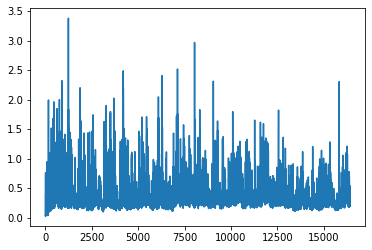

In [51]:
plt.plot(range(len(losses)),losses)

In [ ]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test(model,mode='random',display=False)
    if win:
        wins+=1
        
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}".format(win_perc))